In [1]:
# Dependencies
import json
import hvplot.pandas
import requests
from requests import post
from config import client_secret, client_id
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import missingno as msno

# joining twitchzaggle with additional and games data

In [2]:
# Read the usage_stats.csv file from the Resources folder into a Pandas DataFrame
twitch_zaggle_merged_df = pd.read_csv(
    Path("./Resources/TwitchZaggleMerged.csv")
)
additional_genre = pd.read_csv(
    Path("./Resources/Book1.csv")
)
games = pd.read_csv(
    Path("./Resources/games.csv")
)



C:\Users\nicoo\AppData\Local\Temp\ipykernel_15612\720886357.py:2: DtypeWarning: Columns (6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  twitch_zaggle_merged_df = pd.read_csv(


In [3]:
twitch_zaggle_merged_df.head()

,game,year,metacritic_rating,reviewer_rating,positivity_ratio,rating_x,primary_genre,store_genres,publisher,developer,...,hypes,parent_game,rating_y,rating_count,total_rating,total_rating_count,aggregated_rating,aggregated_rating_count,storyline,franchise
0,The Tiny Bang Story,2011.0,63.0,8.0,7.073879,84.85,Adventure,"['Adventure', 'Casual', 'Indie']",Colibri Games,Colibri Games,...,NaN,NaN,72.926184,28.0,71.463092,29.0,70.0,1.0,NaN,NaN
1,World of Guns: Gun Disassembly,2014.0,NaN,8.0,5.208940,82.09,Free,"['Action', 'Casual', 'Free', 'Indie', 'Simulat...",Noble Empire Corp.,Noble Empire Corp.,...,NaN,NaN,66.706351,8.0,66.706351,8.0,NaN,NaN,NaN,NaN
2,Microsoft Flight Simulator 40th Anniversary Ed...,2020.0,91.0,6.0,3.581082,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hacknet,2015.0,82.0,8.0,14.548520,91.41,Simulation,"['Indie', 'Simulation']",Fellow Traveller,Team Fractal Alligator,...,NaN,NaN,77.907238,31.0,82.953619,32.0,88.0,1.0,"Bit, a hacker responsible for creating the mos...",NaN
4,SpaceChem,2011.0,84.0,8.0,11.440415,88.72,Simulation,"['Indie', 'Simulation']",Zachtronics,Zachtronics,...,NaN,NaN,83.151954,25.0,83.151954,25.0,NaN,NaN,NaN,NaN


In [4]:
#length of the merged data
len(twitch_zaggle_merged_df)

290213

In [5]:
additional_genre.head()

,id,game,total_review,review_score,release_date,launch_price,genre
0,730,Counter-Strike: Global Offensive,7382695,88%,8/21/12,$14.99,"FPS, Shooter, Multiplayer, Competitive, Action..."
1,578080,PUBG: BATTLEGROUNDS,2201296,57%,12/21/17,$29.99,"Survival, Shooter, Battle Royale, Multiplayer,..."
2,570,Dota 2,2017009,82%,7/9/13,$29.99,"Free to Play, MOBA, Multiplayer, Strategy, eSp..."
3,271590,Grand Theft Auto V,1322782,89.85%,4/13/15,$29.99,"Open World, Action, Multiplayer, Crime, Automo..."
4,359550,Tom Clancy's Rainbow Six® Siege,978762,86%,12/1/15,$59.99,"FPS, PvP, eSports, Shooter, Multiplayer, Tacti..."


In [6]:
# #Split the "list" into lists
# additional_genre['genre'] = additional_genre['genre'].str.split(',')
# additional_genre['genre'] = additional_genre['genre'].astype('object')  # Update the data type to 'object'

# print(additional_genre.dtypes)

In [7]:
# Keep the last occurrence of each duplicate based on the 'game' column
additional_genre = additional_genre.drop_duplicates(subset=['game'], keep='last')

# Now, 'additional_genre' has unique values in the 'game' column


In [8]:
# Check for duplicate values in the 'game' column of additional_genre
if additional_genre['game'].duplicated().any():
    print("Warning: Duplicate values found in the 'game' column of additional_genre. Please handle duplicates.")

# Assuming 'game' is a common identifier between twitch_zaggle_merged_df and additional_genre
twitch_zaggle_merged_df['store_genres'] = twitch_zaggle_merged_df['store_genres'].fillna(
    twitch_zaggle_merged_df['game'].map(additional_genre.set_index('game')['genre'])
)


In [9]:
games.head()

,Name,ReleaseDate,ReleaseYear,Developer,Platform,Genres,Publisher,MaxPlayers,ESRB,Overview,Cooperative
0,20th Century Video Almanac,NaN,1993.0,The Software Toolworks,3DO Interactive Multiplayer,Education,The Software Toolworks,1.0,Not Rated,"In The Best of Our Century, we've taken multim...",False
1,3D Atlas,NaN,1994.0,Electronic Arts,3DO Interactive Multiplayer,Education,Electronic Arts,1.0,E - Everyone,3D Atlas for 3DO is an extremely data and art ...,False
2,3DO Action Pak,NaN,1995.0,The 3DO Company,3DO Interactive Multiplayer,Action,The 3DO Company,1.0,Not Rated,This is a four-game compilation pack that cont...,False
3,3DO Demo Disc Program,NaN,NaN,NaN,3DO Interactive Multiplayer,NaN,NaN,NaN,NaN,A white binder with blue silk-screened art. Th...,False
4,3DO Magazine: Interactive Sampler No 02,NaN,NaN,"Crystal Dynamics, Inc.",3DO Interactive Multiplayer,NaN,"Crystal Dynamics, Inc.",1.0,NaN,"Has trailers of Gex, and a game called Cybercl...",False


In [10]:
# Keep the last occurrence of each duplicate based on the 'game' column
games = games.drop_duplicates(subset=['Name'], keep='last')

# Now, 'additional_genre' has unique values in the 'game' column



In [11]:
# Check for duplicate values in the 'game' column of games
if games['Name'].duplicated().any():
    print("Warning: Duplicate values found in the 'Name' column of games. Please handle duplicates.")

# Assuming 'game' is a common identifier between twitch_zaggle_merged_df and games
twitch_zaggle_merged_df['storyline'] = twitch_zaggle_merged_df['storyline'].fillna(
    twitch_zaggle_merged_df['game'].map(games.set_index('Name')['Overview'])
)


In [12]:
twitch_zaggle_merged_df.head()

,game,year,metacritic_rating,reviewer_rating,positivity_ratio,rating_x,primary_genre,store_genres,publisher,developer,...,hypes,parent_game,rating_y,rating_count,total_rating,total_rating_count,aggregated_rating,aggregated_rating_count,storyline,franchise
0,The Tiny Bang Story,2011.0,63.0,8.0,7.073879,84.85,Adventure,"['Adventure', 'Casual', 'Indie']",Colibri Games,Colibri Games,...,NaN,NaN,72.926184,28.0,71.463092,29.0,70.0,1.0,Life on Tiny Planet was calm and carefree unti...,NaN
1,World of Guns: Gun Disassembly,2014.0,NaN,8.0,5.208940,82.09,Free,"['Action', 'Casual', 'Free', 'Indie', 'Simulat...",Noble Empire Corp.,Noble Empire Corp.,...,NaN,NaN,66.706351,8.0,66.706351,8.0,NaN,NaN,World of Guns: Gun Disassembly lets you delve ...,NaN
2,Microsoft Flight Simulator 40th Anniversary Ed...,2020.0,91.0,6.0,3.581082,NaN,NaN,"Simulation, Flight, Realistic, Open World, Mul...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hacknet,2015.0,82.0,8.0,14.548520,91.41,Simulation,"['Indie', 'Simulation']",Fellow Traveller,Team Fractal Alligator,...,NaN,NaN,77.907238,31.0,82.953619,32.0,88.0,1.0,"Bit, a hacker responsible for creating the mos...",NaN
4,SpaceChem,2011.0,84.0,8.0,11.440415,88.72,Simulation,"['Indie', 'Simulation']",Zachtronics,Zachtronics,...,NaN,NaN,83.151954,25.0,83.151954,25.0,NaN,NaN,SpaceChem is a puzzle game about chemical engi...,NaN


In [13]:
# Assuming 'game' is a common identifier between twitch_zaggle_merged_df and additional_genre
twitch_zaggle_merged_df['store_genres'] = twitch_zaggle_merged_df['store_genres'].fillna(
    twitch_zaggle_merged_df['game'].map(games.set_index('Name')['Genres'])
)



In [14]:
# Assuming 'game' is a common identifier between twitch_zaggle_merged_df and additional_genre
twitch_zaggle_merged_df['year'] = twitch_zaggle_merged_df['year'].fillna(
    twitch_zaggle_merged_df['game'].map(games.set_index('Name')['ReleaseYear'])
)



In [15]:
# Assuming 'game' is a common identifier between twitch_zaggle_merged_df and additional_genre
twitch_zaggle_merged_df['publisher'] = twitch_zaggle_merged_df['publisher'].fillna(
    twitch_zaggle_merged_df['game'].map(games.set_index('Name')['Publisher'])
)

In [16]:
len(twitch_zaggle_merged_df)

290213

In [17]:
twitch_zaggle_merged_df['themes']

0         [17, 35]
1          [1, 34]
2              NaN
3             [43]
4             [18]
            ...   
290208     [1, 18]
290209        [18]
290210         NaN
290211         [1]
290212     [1, 18]
Name: themes, Length: 290213, dtype: object

<Axes: >

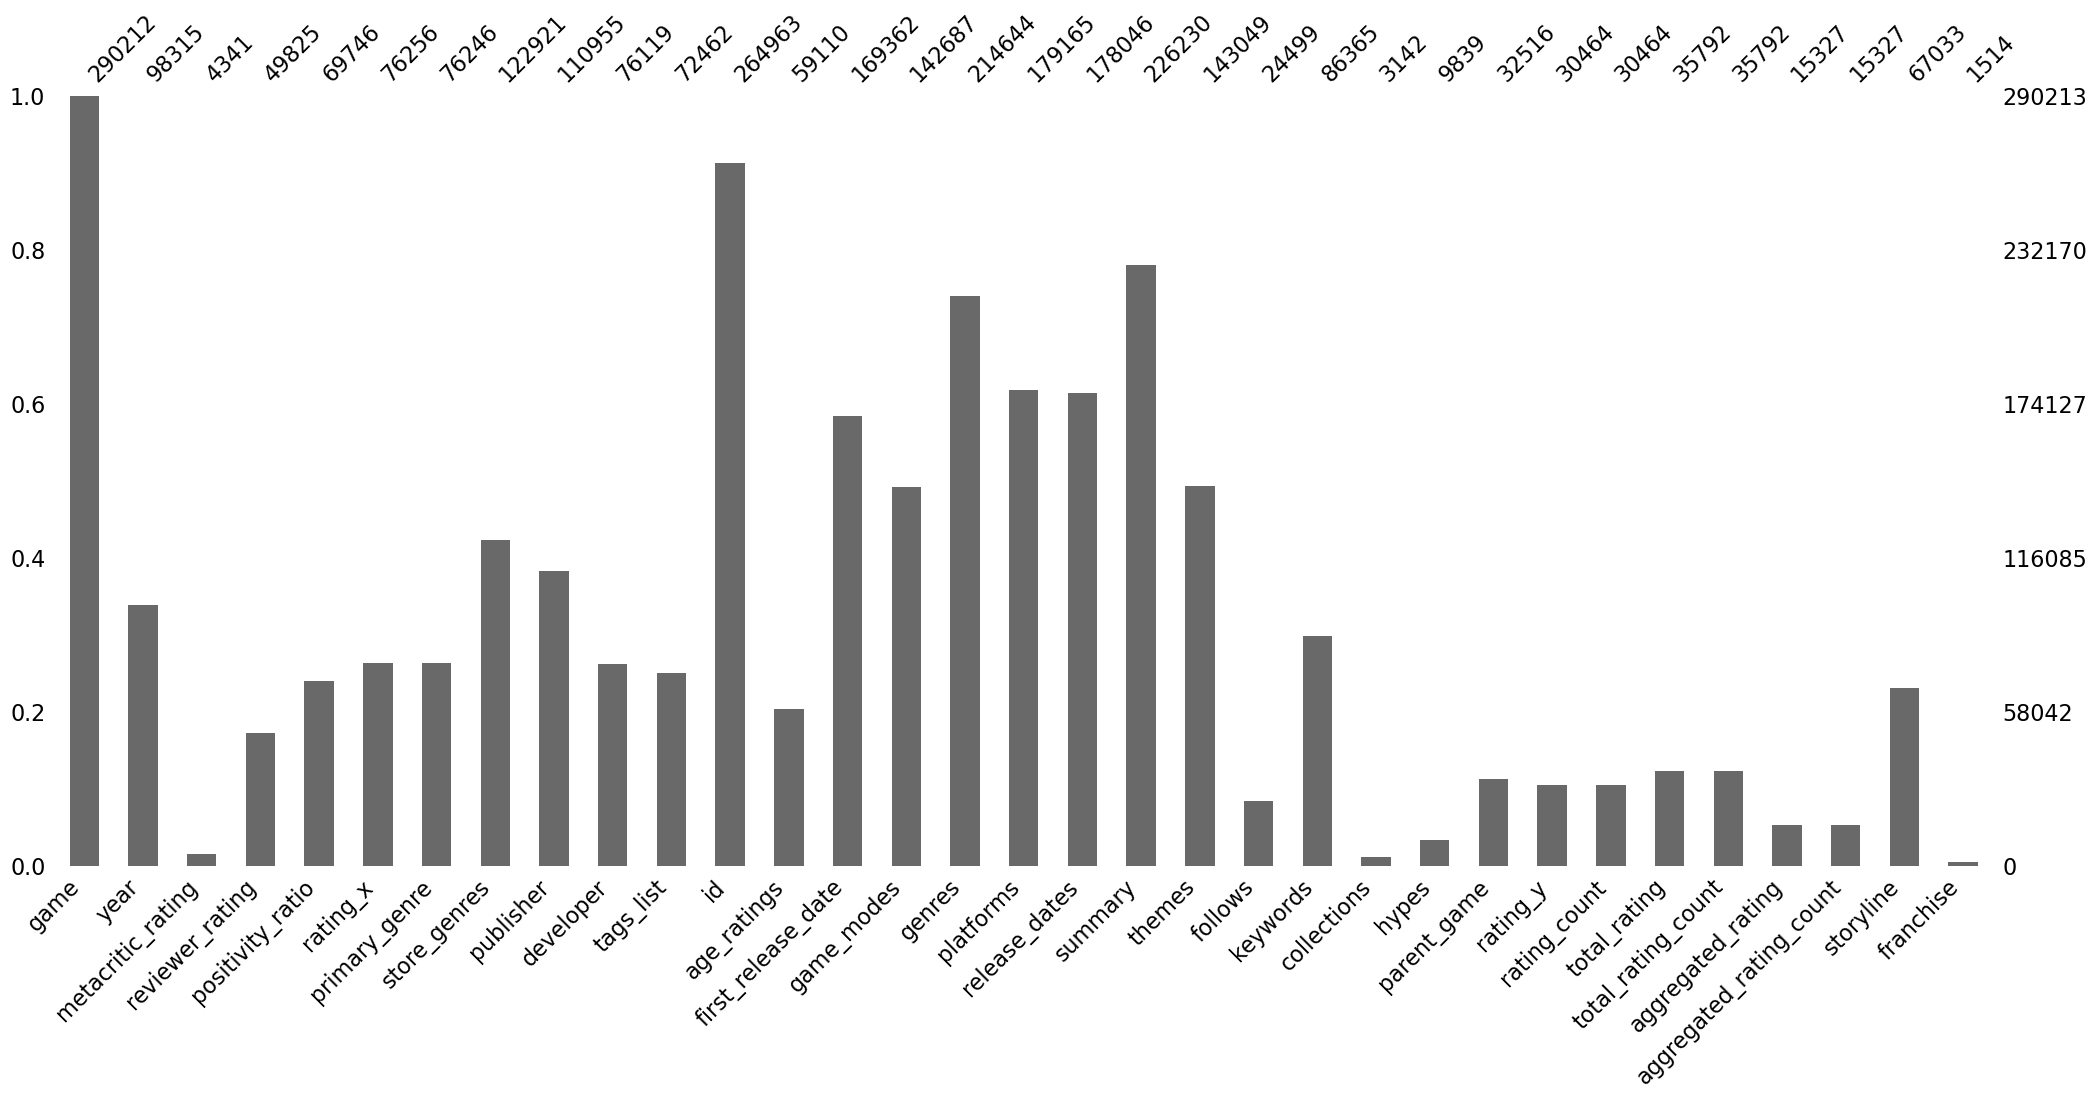

In [18]:
msno.bar(twitch_zaggle_merged_df)

# Dropping NaN Values 

In [19]:
columns_to_drop = ['year', 'age_ratings', 'metacritic_rating', 'rating_x', 'store_genres','publisher','tags_list','primary_genre','release_dates','summary','follows','collections','hypes','parent_game','rating_count', 'total_rating', 'total_rating_count','aggregated_rating','platforms', 'aggregated_rating_count', 'storyline','keywords',
                 'franchise']

# Drop the specified columns
dropped_df = twitch_zaggle_merged_df.drop(columns=columns_to_drop, axis=1)

In [20]:
df_filtered = dropped_df.dropna(thresh=dropped_df.shape[1] - 15)
df_filtered

,game,reviewer_rating,positivity_ratio,developer,id,first_release_date,game_modes,genres,themes,rating_y
0,The Tiny Bang Story,8.0,7.073879,Colibri Games,15120.0,1.303430e+09,[1],"[2, 7, 9, 31, 32]","[17, 35]",72.926184
1,World of Guns: Gun Disassembly,8.0,5.208940,Noble Empire Corp.,7555.0,1.400630e+09,[1],"[5, 9, 13, 32]","[1, 34]",66.706351
2,Microsoft Flight Simulator 40th Anniversary Ed...,6.0,3.581082,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hacknet,8.0,14.548520,Team Fractal Alligator,11707.0,1.439338e+09,[1],"[9, 13, 32]",[43],77.907238
4,SpaceChem,8.0,11.440415,Zachtronics,8390.0,1.293840e+09,[1],"[9, 13, 15, 32]",[18],83.151954
...,...,...,...,...,...,...,...,...,...,...
290208,Enemy Infestation,NaN,NaN,NaN,52526.0,9.071136e+08,"[1, 2, 3]","[11, 15]","[1, 18]",NaN
290209,Sunsoft Collection,NaN,NaN,NaN,79526.0,NaN,NaN,[4],[18],NaN
290210,Free D.C!,NaN,NaN,NaN,80526.0,6.941376e+08,NaN,[31],NaN,NaN
290211,Flip the Gun - Simulator Game,NaN,NaN,NaN,95526.0,1.521590e+09,NaN,[33],[1],90.000000


<Axes: >

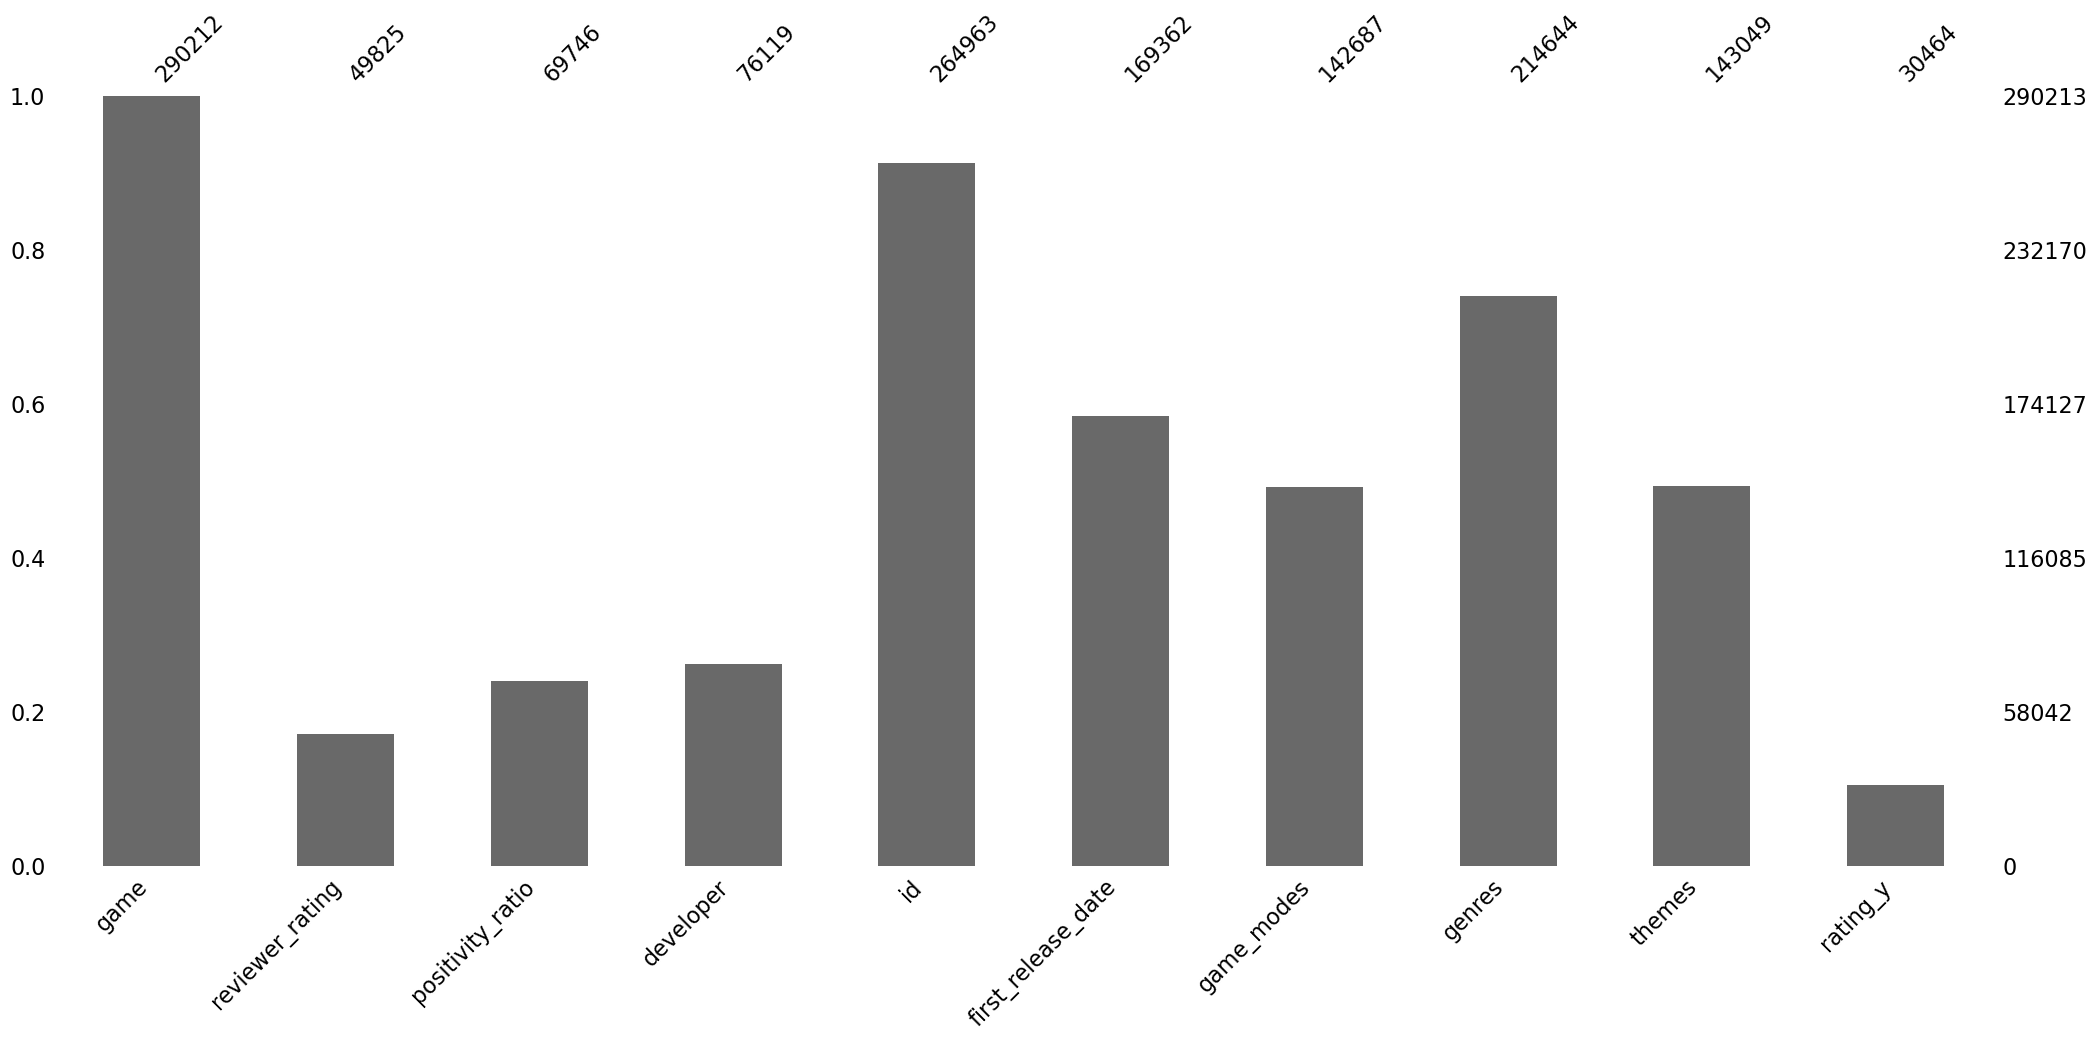

In [21]:
msno.bar(dropped_df)

# cleaning df_filtered

In [22]:
# Round the 'positivity_ratio' column to two decimal places
df_filtered['positivity_ratio'] = df_filtered['positivity_ratio'].round(2)
# fill.na(0)

# Display the modified DataFrame
df_filtered.head()


,game,reviewer_rating,positivity_ratio,developer,id,first_release_date,game_modes,genres,themes,rating_y
0,The Tiny Bang Story,8.0,7.07,Colibri Games,15120.0,1.303430e+09,[1],"[2, 7, 9, 31, 32]","[17, 35]",72.926184
1,World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,7555.0,1.400630e+09,[1],"[5, 9, 13, 32]","[1, 34]",66.706351
2,Microsoft Flight Simulator 40th Anniversary Ed...,6.0,3.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hacknet,8.0,14.55,Team Fractal Alligator,11707.0,1.439338e+09,[1],"[9, 13, 32]",[43],77.907238
4,SpaceChem,8.0,11.44,Zachtronics,8390.0,1.293840e+09,[1],"[9, 13, 15, 32]",[18],83.151954


In [23]:
# Round the 'rating_y' column to two decimal places
df_filtered['rating_y'] = df_filtered['rating_y'].round(2)

# Display the modified DataFrame
df_filtered.head()

,game,reviewer_rating,positivity_ratio,developer,id,first_release_date,game_modes,genres,themes,rating_y
0,The Tiny Bang Story,8.0,7.07,Colibri Games,15120.0,1.303430e+09,[1],"[2, 7, 9, 31, 32]","[17, 35]",72.93
1,World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,7555.0,1.400630e+09,[1],"[5, 9, 13, 32]","[1, 34]",66.71
2,Microsoft Flight Simulator 40th Anniversary Ed...,6.0,3.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hacknet,8.0,14.55,Team Fractal Alligator,11707.0,1.439338e+09,[1],"[9, 13, 32]",[43],77.91
4,SpaceChem,8.0,11.44,Zachtronics,8390.0,1.293840e+09,[1],"[9, 13, 15, 32]",[18],83.15


In [24]:
# # Extract the first number from each list in the 'genres' column
# df_filtered['genres'] = df_filtered['genres'].str[1]

# # Display the modified DataFrame
# df_filtered.head()

df_filtered['genres'] = df_filtered['genres'].str.extract(r'\[(\d+)')[0]

# Display the modified DataFrame
df_filtered.head()

,game,reviewer_rating,positivity_ratio,developer,id,first_release_date,game_modes,genres,themes,rating_y
0,The Tiny Bang Story,8.0,7.07,Colibri Games,15120.0,1.303430e+09,[1],2,"[17, 35]",72.93
1,World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,7555.0,1.400630e+09,[1],5,"[1, 34]",66.71
2,Microsoft Flight Simulator 40th Anniversary Ed...,6.0,3.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hacknet,8.0,14.55,Team Fractal Alligator,11707.0,1.439338e+09,[1],9,[43],77.91
4,SpaceChem,8.0,11.44,Zachtronics,8390.0,1.293840e+09,[1],9,[18],83.15


In [25]:
# # Convert Unix timestamp to datetime and extract year, month, and day
# df_filtered['release_date'] = pd.to_datetime(df_filtered['first_release_date'], unit='s')
# df_filtered['release_year'] = df_filtered['release_date'].dt.year
# df_filtered['release_month'] = df_filtered['release_date'].dt.month
# df_filtered['release_day'] = df_filtered['release_date'].dt.day

# # Display the modified DataFrame with extracted date components
# df_filtered.head()


#shows the year
df_filtered['first_release_date'] = pd.to_datetime(df_filtered['first_release_date'], unit='s').dt.year
df_filtered['first_release_date'] = df_filtered['first_release_date'].fillna(0).astype(int)
# Display the modified DataFrame with the extracted release year
df_filtered.head()

,game,reviewer_rating,positivity_ratio,developer,id,first_release_date,game_modes,genres,themes,rating_y
0,The Tiny Bang Story,8.0,7.07,Colibri Games,15120.0,2011,[1],2,"[17, 35]",72.93
1,World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,7555.0,2014,[1],5,"[1, 34]",66.71
2,Microsoft Flight Simulator 40th Anniversary Ed...,6.0,3.58,NaN,NaN,0,NaN,NaN,NaN,NaN
3,Hacknet,8.0,14.55,Team Fractal Alligator,11707.0,2015,[1],9,[43],77.91
4,SpaceChem,8.0,11.44,Zachtronics,8390.0,2011,[1],9,[18],83.15


In [26]:
### this code takes the first numbers in theme, remove if you want to keep the multiple numbers
df_filtered['themes'] = df_filtered['themes'].str.extract(r'\[(\d+)')[0]

# Display the modified DataFrame
df_filtered.head()

,game,reviewer_rating,positivity_ratio,developer,id,first_release_date,game_modes,genres,themes,rating_y
0,The Tiny Bang Story,8.0,7.07,Colibri Games,15120.0,2011,[1],2,17,72.93
1,World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,7555.0,2014,[1],5,1,66.71
2,Microsoft Flight Simulator 40th Anniversary Ed...,6.0,3.58,NaN,NaN,0,NaN,NaN,NaN,NaN
3,Hacknet,8.0,14.55,Team Fractal Alligator,11707.0,2015,[1],9,43,77.91
4,SpaceChem,8.0,11.44,Zachtronics,8390.0,2011,[1],9,18,83.15


In [27]:
### this code takes the first numbers in game_modes, remove if you want to keep the multiple numbers
df_filtered['game_modes'] = df_filtered['game_modes'].str.extract(r'\[(\d+)')[0]

# Display the modified DataFrame
df_filtered.head()

,game,reviewer_rating,positivity_ratio,developer,id,first_release_date,game_modes,genres,themes,rating_y
0,The Tiny Bang Story,8.0,7.07,Colibri Games,15120.0,2011,1,2,17,72.93
1,World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,7555.0,2014,1,5,1,66.71
2,Microsoft Flight Simulator 40th Anniversary Ed...,6.0,3.58,NaN,NaN,0,NaN,NaN,NaN,NaN
3,Hacknet,8.0,14.55,Team Fractal Alligator,11707.0,2015,1,9,43,77.91
4,SpaceChem,8.0,11.44,Zachtronics,8390.0,2011,1,9,18,83.15


In [28]:
df_filtered.drop(columns = ['id'], inplace = True)

# saving df_filtered as csv

In [29]:
df_filtered.to_csv('Resources/df_filtered.csv', index=False)

# Numbering Genres

In [30]:
# nan_count = twitch_zaggle_merged_df['primary_genre'].isna().sum()

# print("Number of NaN values in 'primary_genre':", nan_count)


In [31]:

# # Load the genre API CSV containing genre mapping
# genre_api_df = pd.read_csv("./Resources/genre_api.csv")

# # Define a function to map genre names to numerical IDs
# def map_genres_to_ids(genre_list):
#     try:
#         # Convert the string to an actual list
#         genres = eval(genre_list)

#         # Map each genre name to its corresponding numerical ID
#         mapped_ids = [genre_api_df.loc[genre_api_df['name'] == genre, 'id'].values[0] for genre in genres]

#         return mapped_ids
#     except:
#         # If there's an issue (e.g., non-list format), return an empty list
#         return []

# # Apply the mapping function to the 'tags_list' column
# twitch_zaggle_merged_df['mapped_ids'] = twitch_zaggle_merged_df['tags_list'].apply(map_genres_to_ids)

# # Display the result
# print(twitch_zaggle_merged_df[['tags_list', 'mapped_ids']])


In [32]:
# (twitch_zaggle_merged_df[['tags_list', 'mapped_genres']])

# K-Means Clustering

In [33]:
df_filtered.set_index('game', inplace=True)
df_filtered

,reviewer_rating,positivity_ratio,developer,first_release_date,game_modes,genres,themes,rating_y
game,,,,,,,,
The Tiny Bang Story,8.0,7.07,Colibri Games,2011,1,2,17,72.93
World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,2014,1,5,1,66.71
Microsoft Flight Simulator 40th Anniversary Edition,6.0,3.58,NaN,0,NaN,NaN,NaN,NaN
Hacknet,8.0,14.55,Team Fractal Alligator,2015,1,9,43,77.91
SpaceChem,8.0,11.44,Zachtronics,2011,1,9,18,83.15
...,...,...,...,...,...,...,...,...
Enemy Infestation,NaN,NaN,NaN,1998,1,11,1,NaN
Sunsoft Collection,NaN,NaN,NaN,0,NaN,4,18,NaN
Free D.C!,NaN,NaN,NaN,1991,NaN,31,NaN,NaN


In [34]:
# Generate summary statistics
# df_filtered.describe()

In [35]:
# df_filtered.shape

In [36]:
# Plot your data to see what's in your DataFrame
#twitch_zaggle_merged_df.hvplot.line(
#    width=800,
#    height=400,
#    rot=90
#)

# Prepare the Data

In [37]:
df_filtered.columns

Index(['reviewer_rating', 'positivity_ratio', 'developer',
       'first_release_date', 'game_modes', 'genres', 'themes', 'rating_y'],
      dtype='object')

In [38]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290213 entries, The Tiny Bang Story to Bomb Rush Cyberfunk
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   reviewer_rating     49825 non-null   float64
 1   positivity_ratio    69746 non-null   float64
 2   developer           76119 non-null   object 
 3   first_release_date  290213 non-null  int32  
 4   game_modes          142687 non-null  object 
 5   genres              214644 non-null  object 
 6   themes              143049 non-null  object 
 7   rating_y            30464 non-null   float64
dtypes: float64(3), int32(1), object(4)
memory usage: 18.8+ MB


<Axes: >

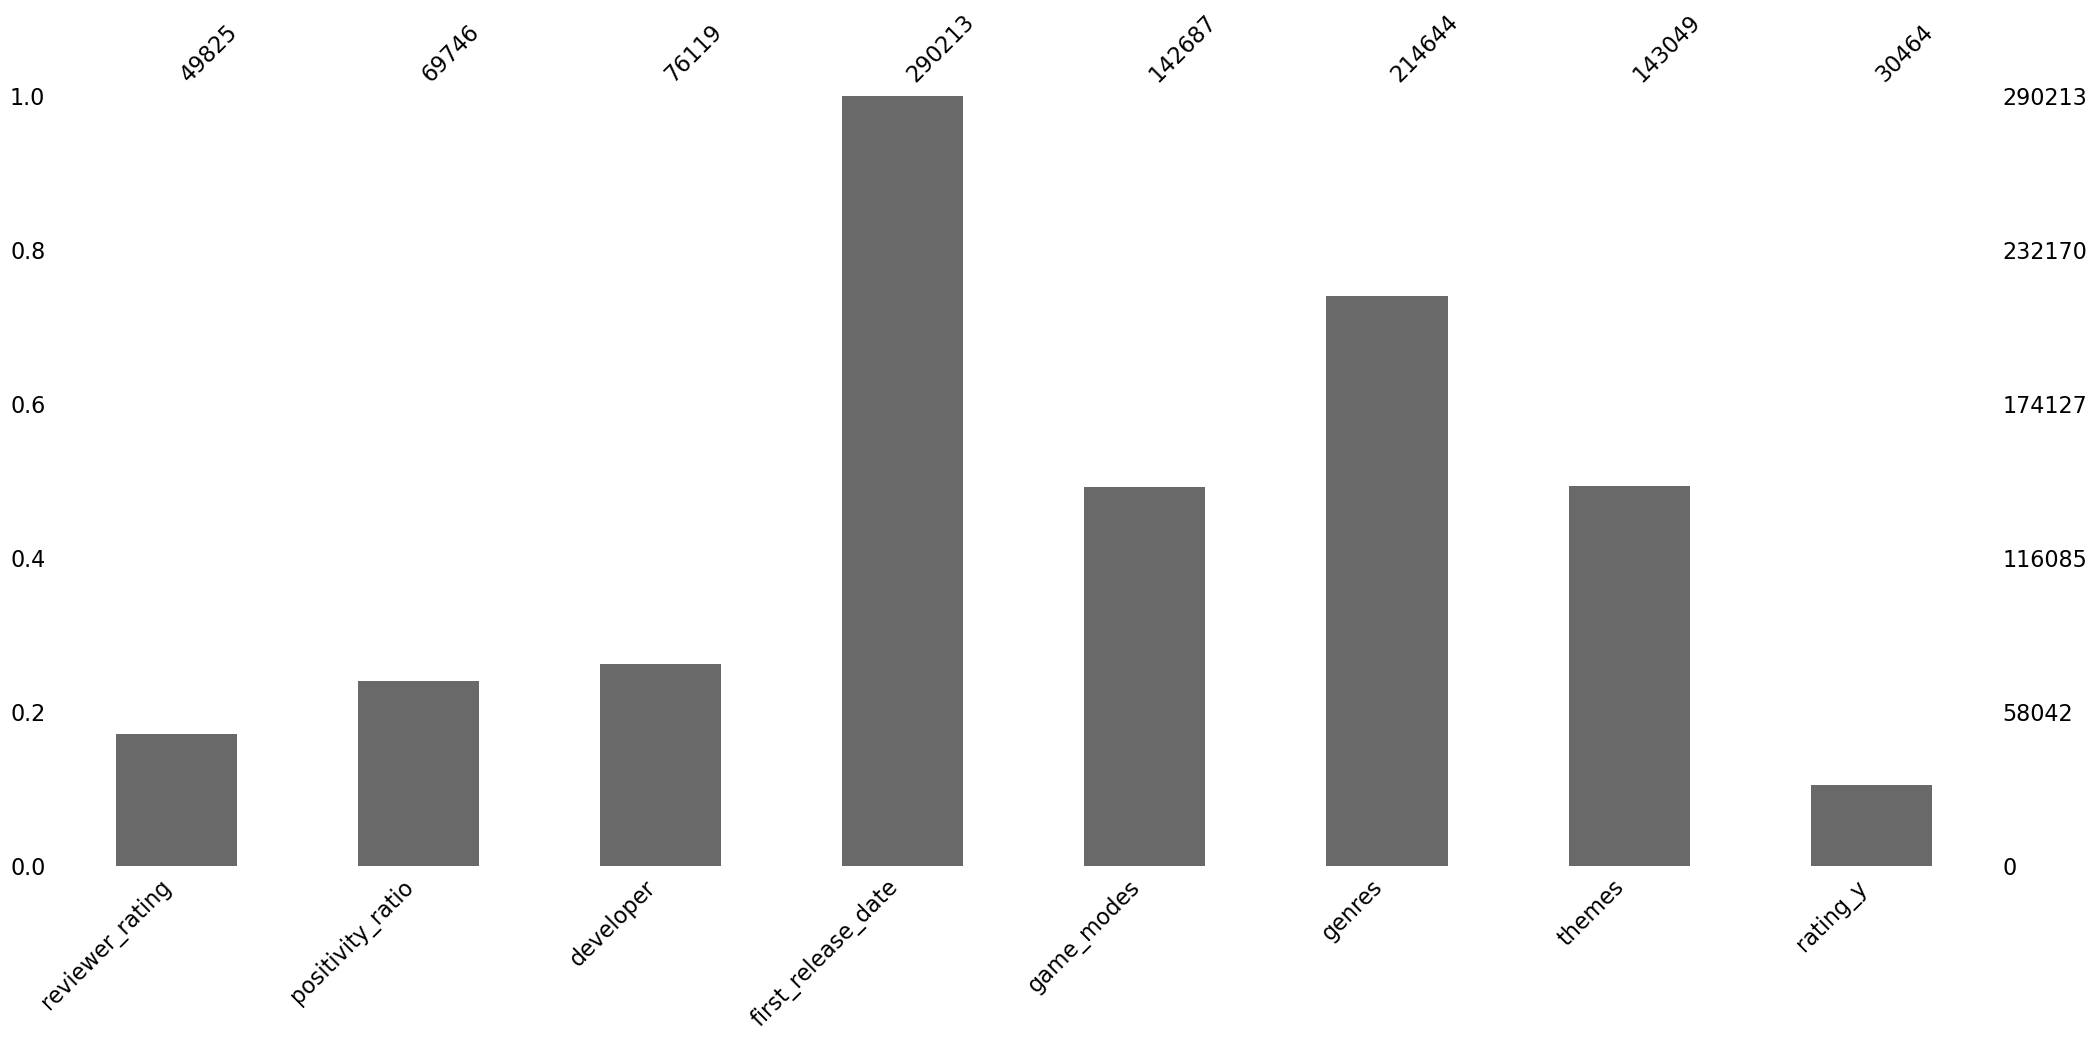

In [39]:
import missingno as msno

msno.bar(df_filtered)

In [40]:
# pip install missingno

<Axes: >

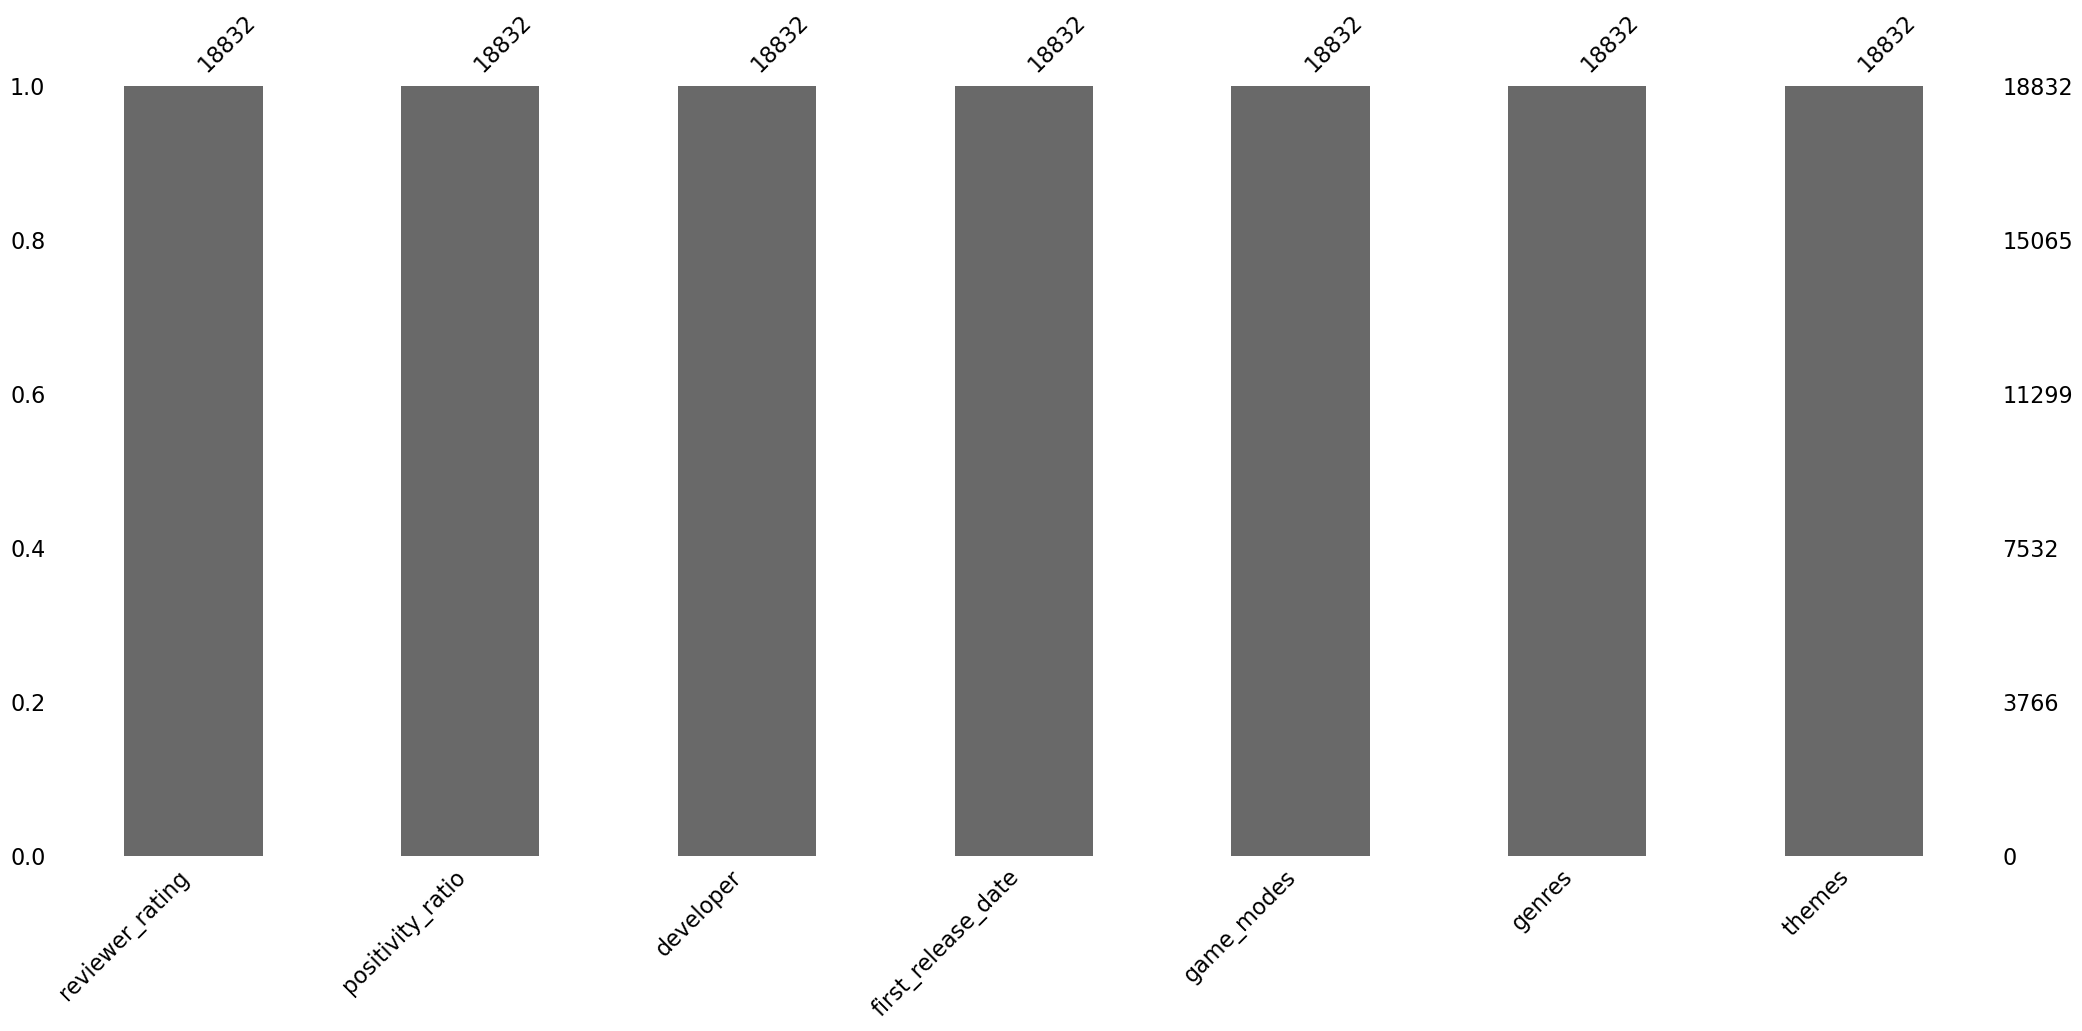

In [41]:
msno.bar(df_filtered.drop(columns = 'rating_y').dropna(how = 'any'))
#cannot imput this because its over 20% of the data missing, so we are going about it this way

In [42]:
df_dropped = df_filtered.drop(columns = 'rating_y').dropna(how = 'any')
df_dropped

,reviewer_rating,positivity_ratio,developer,first_release_date,game_modes,genres,themes
game,,,,,,,
The Tiny Bang Story,8.0,7.07,Colibri Games,2011,1,2,17
World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,2014,1,5,1
Hacknet,8.0,14.55,Team Fractal Alligator,2015,1,9,43
SpaceChem,8.0,11.44,Zachtronics,2011,1,9,18
Learn to Fly 3,8.0,15.57,Light Bringer Games inc.,2017,1,13,1
...,...,...,...,...,...,...,...
Omega Agent,6.0,3.15,Fireproof Games,2016,1,5,1
Time of Shadows,4.0,0.58,SkyFallen Entertainment,2009,1,12,1
Drug Wars,4.0,0.42,Paleo Entertainment,2009,1,5,1


In [43]:
# Identify columns with missing values
# columns_with_missing_values = df_filtered.columns[df_filtered.isnull().any()].tolist()
# columns_with_missing_values
#not dropping these anymore due to the avoidance of imputing

In [44]:
# df_filtered.drop(columns = columns_with_missing_values, inplace = True)
# df_filtered

In [45]:
# for column in columns_with_missing_values:
#     print(f"Processing column: {column}")
    
#     if twitch_zaggle_merged_df[column].dtype == 'float64':
#         imputer = SimpleImputer(strategy='mean')
#     else:
#         imputer = SimpleImputer(strategy='most_frequent')
    
#     # Flatten lists and handle NaN values
#     flattened_values = twitch_zaggle_merged_df[column].apply(lambda x: x if isinstance(x, list) else [x])
#     flattened_values = flattened_values.apply(lambda x: x[0] if len(x) > 0 else np.nan)
    
#     imputed_values = imputer.fit_transform(flattened_values.values.reshape(-1, 1)).ravel()
    
#     print(f"Imputed values: {imputed_values}")
    
#     # Update the DataFrame using loc
#     twitch_zaggle_merged_df.loc[:, column] = imputed_values


# for column in columns_with_missing_values:
#     print(f"Processing column: {column}")
    
#     if df_filtered[column].dtype == 'float64':
#         imputed_values = df_filtered[column].fillna(df_filtered[column].mean())
#     else:
#         # For non-numeric columns, fill missing values with the most frequent value
#         most_frequent_value = df_filtered[column].mode().iloc[0]
#         imputed_values = df_filtered[column].fillna(most_frequent_value)
    
#     print(f"Imputed values: {imputed_values}")
    
#     # Update the DataFrame using loc
#     df_filtered.loc[:, column] = imputed_values



<Axes: ylabel='Frequency'>

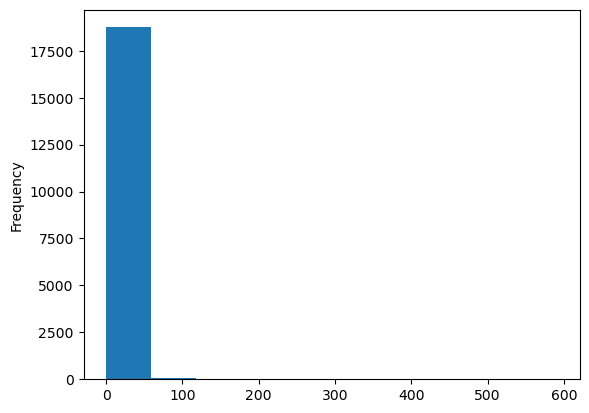

In [46]:
df_dropped.positivity_ratio.plot.hist()

<Axes: >

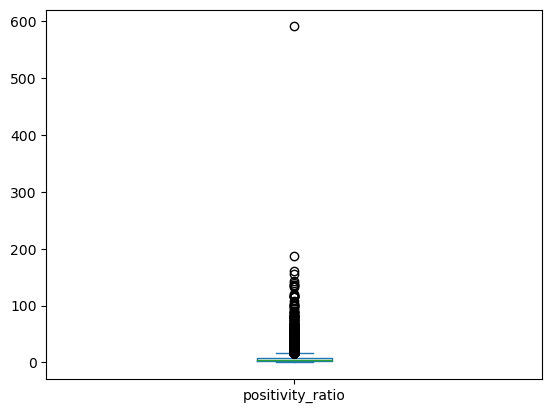

In [47]:
df_dropped.positivity_ratio.plot.box()

In [48]:
# Generate summary statistics
df_dropped.describe(include='all')

,reviewer_rating,positivity_ratio,developer,first_release_date,game_modes,genres,themes
count,18832.000000,18832.000000,18832,18832.000000,18832,18832,18832
unique,NaN,NaN,12222,NaN,6,23,22
top,NaN,NaN,RewindApp,NaN,1,12,1
freq,NaN,NaN,35,NaN,17861,2871,13335
mean,6.488955,6.613152,NaN,1959.860875,NaN,NaN,NaN
std,1.387789,10.244790,NaN,333.578755,NaN,NaN,NaN
min,1.000000,0.040000,NaN,0.000000,NaN,NaN,NaN
25%,5.000000,1.790000,NaN,2015.000000,NaN,NaN,NaN
50%,7.000000,3.640000,NaN,2018.000000,NaN,NaN,NaN
75%,8.000000,7.652500,NaN,2020.000000,NaN,NaN,NaN


In [49]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18832 entries, The Tiny Bang Story to Sangokushi Eiketsuden
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviewer_rating     18832 non-null  float64
 1   positivity_ratio    18832 non-null  float64
 2   developer           18832 non-null  object 
 3   first_release_date  18832 non-null  int32  
 4   game_modes          18832 non-null  object 
 5   genres              18832 non-null  object 
 6   themes              18832 non-null  object 
dtypes: float64(2), int32(1), object(4)
memory usage: 1.1+ MB


In [50]:
df_dropped[['game_modes','genres','themes']] = df_dropped[['game_modes','genres','themes']].astype('int')
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18832 entries, The Tiny Bang Story to Sangokushi Eiketsuden
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviewer_rating     18832 non-null  float64
 1   positivity_ratio    18832 non-null  float64
 2   developer           18832 non-null  object 
 3   first_release_date  18832 non-null  int32  
 4   game_modes          18832 non-null  int32  
 5   genres              18832 non-null  int32  
 6   themes              18832 non-null  int32  
dtypes: float64(2), int32(4), object(1)
memory usage: 882.8+ KB


In [51]:
df_dropped.describe(include='all')

,reviewer_rating,positivity_ratio,developer,first_release_date,game_modes,genres,themes
count,18832.000000,18832.000000,18832,18832.000000,18832.000000,18832.000000,18832.000000
unique,NaN,NaN,12222,NaN,NaN,NaN,NaN
top,NaN,NaN,RewindApp,NaN,NaN,NaN,NaN
freq,NaN,NaN,35,NaN,NaN,NaN,NaN
mean,6.488955,6.613152,NaN,1959.860875,1.060217,14.695731,7.926349
std,1.387789,10.244790,NaN,333.578755,0.303075,9.933592,11.842565
min,1.000000,0.040000,NaN,0.000000,1.000000,2.000000,1.000000
25%,5.000000,1.790000,NaN,2015.000000,1.000000,8.000000,1.000000
50%,7.000000,3.640000,NaN,2018.000000,1.000000,12.000000,1.000000
75%,8.000000,7.652500,NaN,2020.000000,1.000000,15.000000,17.000000


In [52]:
df_dropped.shape

(18832, 7)

# Prepare the Data

In [53]:
df_dropped.head()

,reviewer_rating,positivity_ratio,developer,first_release_date,game_modes,genres,themes
game,,,,,,,
The Tiny Bang Story,8.0,7.07,Colibri Games,2011,1,2,17
World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,2014,1,5,1
Hacknet,8.0,14.55,Team Fractal Alligator,2015,1,9,43
SpaceChem,8.0,11.44,Zachtronics,2011,1,9,18
Learn to Fly 3,8.0,15.57,Light Bringer Games inc.,2017,1,13,1


In [54]:
# # Find rows with string representations of lists in the 'tags_list' column
# problematic_rows = twitch_zaggle_merged_df[twitch_zaggle_merged_df['tags_list'].apply(lambda x: isinstance(x, str) and '[' in x and ']' in x)]

# # Print the problematic rows
# print(problematic_rows[['tags_list']])

In [55]:
# Extract the second value from the "age_ratings" column and remove square brackets
# df_filtered['age_ratings'] = df_filtered['age_ratings'].str.extract('\[\d+, (\d+)').astype(float)

# # Print unique values in the column after conversion
# print("Unique values after conversion:", df_filtered['age_ratings'].unique())

#ended up removing because the api did not hook up to the other age rating api so it was not able to figure out what the 
#numbers mean

In [56]:
df_dropped.tail()

,reviewer_rating,positivity_ratio,developer,first_release_date,game_modes,genres,themes
game,,,,,,,
Omega Agent,6.0,3.15,Fireproof Games,2016,1,5,1
Time of Shadows,4.0,0.58,SkyFallen Entertainment,2009,1,12,1
Drug Wars,4.0,0.42,Paleo Entertainment,2009,1,5,1
Uncharted Waters,7.0,6.00,KOEI TECMO GAMES CO. LTD.,1990,1,12,17
Sangokushi Eiketsuden,6.0,3.15,KOEI TECMO GAMES CO. LTD.,1995,1,12,17


In [57]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18832 entries, The Tiny Bang Story to Sangokushi Eiketsuden
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviewer_rating     18832 non-null  float64
 1   positivity_ratio    18832 non-null  float64
 2   developer           18832 non-null  object 
 3   first_release_date  18832 non-null  int32  
 4   game_modes          18832 non-null  int32  
 5   genres              18832 non-null  int32  
 6   themes              18832 non-null  int32  
dtypes: float64(2), int32(4), object(1)
memory usage: 882.8+ KB


In [58]:
df_dropped.dtypes

reviewer_rating       float64
positivity_ratio      float64
developer              object
first_release_date      int32
game_modes              int32
genres                  int32
themes                  int32
dtype: object

In [59]:
# List of columns to be one-hot encoded
columns_to_encode = ['developer', 'game_modes', 'genres', 'themes']

# Use pd.get_dummies to perform one-hot encoding
df_encoded = pd.get_dummies(df_dropped, columns=columns_to_encode)

# Display the first few rows of the encoded DataFrame
df_encoded.head()

,reviewer_rating,positivity_ratio,first_release_date,developer_#workshop,developer_&quot;Nieko&quot;,developer_&quot;RevDay Studio&quot;,developer_+7 Software,developer_+Mpact Games LLC.,developer_.Cat,developer_.ez Games,...,themes_33,themes_34,themes_35,themes_38,themes_39,themes_40,themes_41,themes_42,themes_43,themes_44
game,,,,,,,,,,,,,,,,,,,,,
The Tiny Bang Story,8.0,7.07,2011,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
World of Guns: Gun Disassembly,8.0,5.21,2014,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Hacknet,8.0,14.55,2015,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
SpaceChem,8.0,11.44,2011,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Learn to Fly 3,8.0,15.57,2017,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [60]:
df_dropped.developer.value_counts()

developer
RewindApp                     35
Ripknot Systems               31
CAPCOM Co. Ltd.               29
Kairosoft Co.Ltd              29
Winged Cloud                  28
                              ..
WyvernWare                     1
Garden Shed Studios            1
Lead Money Games               1
Draconus Entertainment Ltd     1
Paleo Entertainment            1
Name: count, Length: 12222, dtype: int64

In [61]:
#put the ones who show up only once then we want to bin these --in deep learning homework 
#check if there are typos or doubles
#distant base make sure to scale it
#user input through website, then use predict, take in all info to predict

In [62]:
print(df_dropped['developer'].isna().sum())
print(df_dropped['game_modes'].isna().sum())

0
0


In [63]:
print(df_dropped['developer'].dtype)
print(df_dropped['game_modes'].dtype)

object
int32


In [64]:
print(df_dropped['developer'].nunique())
print(df_dropped['game_modes'].nunique())

12222
6


In [65]:
df_encoded = pd.get_dummies(df_dropped, columns=['game_modes'])

In [66]:
# df_filtered['age_ratings'] = df_filtered['age_ratings'].astype('category')
# df_encoded = pd.get_dummies(df_filtered, columns=['age_ratings'])
# doing age_ratings in this way created over 50k columns, so changing it to an alternative strategy
# label_encoder = LabelEncoder()
# df_encoded['age_ratings'] = label_encoder.fit_transform(df_filtered['age_ratings'])

In [67]:
# label_encoder = LabelEncoder()
# df_filtered['developer_encoded'] = label_encoder.fit_transform(df_filtered['developer'])

In [68]:
# print("Unique values before label encoding:", df_filtered['developer'].nunique())
# label_encoder = LabelEncoder()
# df_filtered['developer_encoded'] = label_encoder.fit_transform(df_filtered['developer'])
# print("Unique values after label encoding:", df_filtered['developer_encoded'].nunique())

In [69]:
# df_encoded.columns
#if encoding it will see it as heiracrhical 

In [70]:
# print(df_filtered[['developer', 'developer_encoded']].head())

In [71]:
# # Perform label encoding on 'developer'
# label_encoder = LabelEncoder()
# df_filtered['developer_encoded'] = label_encoder.fit_transform(df_filtered['developer'])

# # List of columns to be one-hot encoded
# columns_to_encode = ['game_modes']

# # Use pd.get_dummies to perform one-hot encoding
# df_encoded = pd.get_dummies(df_filtered, columns=columns_to_encode)

# # Concatenate 'developer_encoded' column to df_encoded
# df_encoded = pd.concat([df_encoded, df_filtered['developer_encoded']], axis=1)

# # Display the first few rows of the concatenated DataFrame
# print(df_encoded.head())

In [72]:
df_encoded.columns

Index(['reviewer_rating', 'positivity_ratio', 'developer',
       'first_release_date', 'genres', 'themes', 'game_modes_1',
       'game_modes_2', 'game_modes_3', 'game_modes_4', 'game_modes_5',
       'game_modes_6'],
      dtype='object')

In [73]:
df_encoded

,reviewer_rating,positivity_ratio,developer,first_release_date,genres,themes,game_modes_1,game_modes_2,game_modes_3,game_modes_4,game_modes_5,game_modes_6
game,,,,,,,,,,,,
The Tiny Bang Story,8.0,7.07,Colibri Games,2011,2,17,True,False,False,False,False,False
World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,2014,5,1,True,False,False,False,False,False
Hacknet,8.0,14.55,Team Fractal Alligator,2015,9,43,True,False,False,False,False,False
SpaceChem,8.0,11.44,Zachtronics,2011,9,18,True,False,False,False,False,False
Learn to Fly 3,8.0,15.57,Light Bringer Games inc.,2017,13,1,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
Omega Agent,6.0,3.15,Fireproof Games,2016,5,1,True,False,False,False,False,False
Time of Shadows,4.0,0.58,SkyFallen Entertainment,2009,12,1,True,False,False,False,False,False
Drug Wars,4.0,0.42,Paleo Entertainment,2009,5,1,True,False,False,False,False,False


In [74]:
df_filtered

,reviewer_rating,positivity_ratio,developer,first_release_date,game_modes,genres,themes,rating_y
game,,,,,,,,
The Tiny Bang Story,8.0,7.07,Colibri Games,2011,1,2,17,72.93
World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,2014,1,5,1,66.71
Microsoft Flight Simulator 40th Anniversary Edition,6.0,3.58,NaN,0,NaN,NaN,NaN,NaN
Hacknet,8.0,14.55,Team Fractal Alligator,2015,1,9,43,77.91
SpaceChem,8.0,11.44,Zachtronics,2011,1,9,18,83.15
...,...,...,...,...,...,...,...,...
Enemy Infestation,NaN,NaN,NaN,1998,1,11,1,NaN
Sunsoft Collection,NaN,NaN,NaN,0,NaN,4,18,NaN
Free D.C!,NaN,NaN,NaN,1991,NaN,31,NaN,NaN
